In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.optimizers import Adam

# Data preparation

In [2]:
data_path = "/Users/wilkie/data/smart_pixels_13/unflipped/"

In [3]:
pq1 = pd.read_parquet(data_path + "recon2D_d17501.parquet")

In [4]:
def take_yprofile(data):
    data = np.array(data)
    #reshape to 2D
    data = np.reshape(data, (13, 21))
    #take the y-profile
    profile = np.sum(data, axis=1)
    return profile


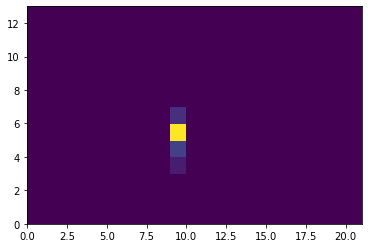

In [5]:
arr = np.array(pq1.iloc[0])
plt.pcolor(np.reshape(arr, (13, 21)))

In [6]:
prof = take_yprofile(pq1.iloc[0])

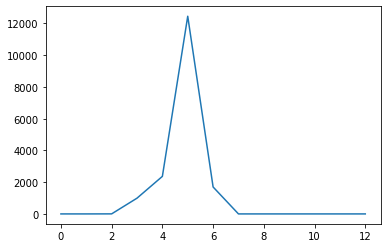

In [7]:
plt.plot(prof)

In [8]:
pq1_truth = pd.read_parquet(data_path + "labels_d17501.parquet")

In [9]:
pq1_truth

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,y-local,pt,cotAlpha,cotBeta,y-midplane,x-midplane
0,-48.731285,2.872706,100.0,-0.239328,-0.141072,-1.238494,17510.0,-3.83818,-1.2465,0.193241,0.113906,-2.822598,-58.393342
1,-175.338928,25.938915,100.0,0.809492,-0.089265,-0.325481,17308.0,-6.57575,0.3375,-2.487064,0.274256,12.226133,-50.985740
2,177.558731,9.934172,100.0,-0.312144,-0.010484,-0.115023,43849.0,-7.47091,-0.1155,2.713753,0.091147,5.376823,41.871086
3,-418.620941,-10.610765,100.0,6.665171,-0.050723,-0.797890,66669.0,-2.55476,-0.7995,-8.353496,0.063571,-13.789336,-0.946136
4,-346.192657,0.553267,100.0,5.683409,-0.086886,-1.020810,51912.0,-2.04856,1.0245,-5.567548,0.085115,-3.702471,-67.815241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,48.692581,-14.837375,100.0,-0.620369,0.008676,-0.264358,29911.0,-0.95797,-0.2645,2.346700,-0.032819,-13.196418,-68.642434
49968,42.802876,4.589038,100.0,0.006787,-0.041867,-0.095746,15935.0,-7.43155,0.1045,-0.070885,0.437272,-17.274539,46.347149
49969,-301.871185,-10.112600,100.0,2.982382,0.074379,-0.573699,76986.0,4.80660,0.5785,-5.198514,-0.129648,-3.630194,-41.945510
49970,372.125732,-14.596362,100.0,-0.350652,0.024985,-0.050675,51510.0,4.44579,-0.0565,6.919625,-0.493044,10.055833,26.144479


In [10]:
def get_training(charge_file, truth_file):
    xs = []
    ys = []

    for idx, row in charge_file.iterrows():
        profile = take_yprofile(row)
        truth = truth_file.iloc[idx]
        y_local = np.array(truth["y-local"])
        pt = np.array(truth["pt"])

        x = np.concatenate((profile, [y_local]))
        y = pt

        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

        

In [11]:
prof, pt = get_training(pq1, pq1_truth)

In [42]:
def build_set(train_start, train_stop):
    n_files = train_stop - train_start

    train_files_charge = ["recon2D_d" + str(i) + ".parquet" for i in range(train_start, train_stop)]
    train_files_truth = ["labels_d" + str(i) + ".parquet" for i in range(train_start, train_stop)]

    data_files_train = [pd.read_parquet(data_path + f) for f in train_files_charge]
    truth_files_train = [pd.read_parquet(data_path + f) for f in train_files_truth]

    train_data = [get_training(data_files_train[i], truth_files_train[i]) for i in range(1, n_files)]

    X_train = np.concatenate([d[0] for d in train_data], axis=0)
    y_train = np.concatenate([d[1] for d in train_data], axis=0)
    y_train = np.reshape(y_train, (-1, 1))

    return X_train, y_train


In [43]:
train_start = 17501
train_stop = 17510

In [84]:
X_train, y_pt_train = build_set(17501, 17510)

In [82]:
X_train.shape

(399800, 14)

In [86]:
y_pt_train.shape

(399800, 1)

In [47]:
#original is 652,160 samples

In [85]:
X_test, y_pt_test = build_set(17511, 17513)

In [73]:
X_test.shape

(49978, 14)

In [88]:
y_pt_test.shape

(49978, 1)

In [113]:
X_test_huge, y_pt_test_huge = build_set(17514, 17534)

In [89]:
def get_truth(momenta, threshold):
    return 1.0 * (momenta > threshold) + 2.0 * (momenta < -1 * threshold)

In [90]:
threshold = 1.0

In [93]:
y_train = get_truth(y_pt_train, threshold)

In [94]:
y_test = get_truth(y_pt_test, threshold)

In [114]:
y_test_huge = get_truth(y_pt_test_huge, threshold)

(array([340715.,      0.,      0.,      0.,      0.,  29668.,      0.,
             0.,      0.,  29417.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

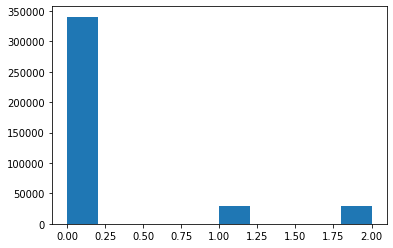

In [95]:
plt.hist(y_train)

In [96]:
#original is 3,597,877 test samples

# Training

In [97]:
# X_train = df1.values
# X_test = df3.values

# y_train = df2.values
# y_test = df4.values
# #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(399800, 14) (49978, 14) (399800, 1) (49978, 1)


In [98]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
xform = lambda x: scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
X_test = xform(X_test)
X_test_huge = xform(X_test_huge)

In [99]:
X_test

array([[-0.09065452, -0.16387905, -0.37947249, ..., -0.06253624,
        -0.05523033,  1.08292286],
       [-0.09065452, -0.16387905, -0.37818124, ..., -0.06253624,
        -0.05523033, -1.3539787 ],
       [-0.09065452, -0.16387905, -0.37947249, ..., -0.06253624,
        -0.05523033, -1.15795256],
       ...,
       [-0.09065452, -0.16387905, -0.37918196, ..., -0.06253624,
        -0.05523033,  1.54038564],
       [-0.09065452, -0.16387905, -0.37947249, ..., -0.06253624,
        -0.05523033,  0.60751058],
       [-0.09065452, -0.16387905,  0.74908584, ..., -0.06253624,
        -0.05523033, -0.82711593]])

In [100]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(14,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 14)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               1920      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
_________________________________________________________________


In [101]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Epoch 1/200
313/313 [==============================] - 3s 7ms/step - loss: 0.5514 - sparse_categorical_accuracy: 0.8497 - val_loss: 0.5260 - val_sparse_categorical_accuracy: 0.8531
Epoch 2/200
313/313 [==============================] - 2s 7ms/step - loss: 0.5248 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.5201 - val_sparse_categorical_accuracy: 0.8531
Epoch 3/200
313/313 [==============================] - 2s 7ms/step - loss: 0.5207 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.5172 - val_sparse_categorical_accuracy: 0.8531
Epoch 4/200
313/313 [==============================] - 2s 7ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.5155 - val_sparse_categorical_accuracy: 0.8531
Epoch 5/200
313/313 [==============================] - 2s 7ms/step - loss: 0.5166 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.5143 - val_sparse_categorical_accuracy: 0.8531
Epoch 6/200
313/313 [==============================] - 2s 7ms/step - loss: 0.5155 - sparse_cate

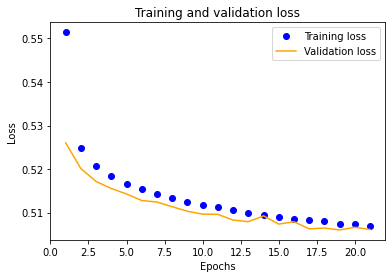

In [102]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

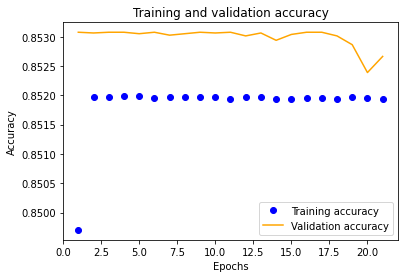

In [103]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [135]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

1562/1562 [==============================] - 3s 2ms/step


(array([    0.,     0.,     0.,     0.,     0., 49978.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

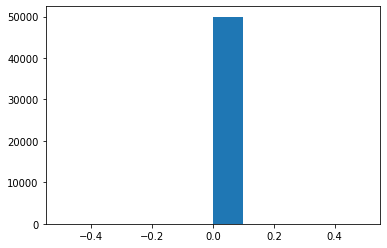

In [105]:
plt.hist(predictionsFiles)

In [106]:
#pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [107]:
#pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [108]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5242260694503784
Test accuracy: 0.8532954454421997


Confusion matrix:
[[42646     0     0]
 [ 3619     0     0]
 [ 3713     0     0]]


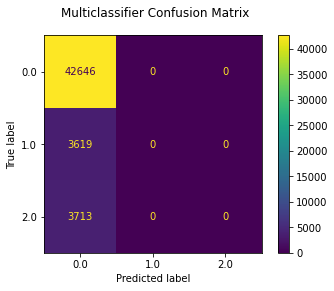

In [109]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()

In [115]:
X_test_huge.shape

(949495, 14)

In [117]:
preds_huge = model.predict(X_test_huge) 
predictionsFiles_huge =np.argmax(preds, axis=1)

29672/29672 [==============================] - 52s 2ms/step


NameError: name 'preds_huge' is not defined

Confusion matrix:
[[795557  14003    124]
 [ 69672    355      7]
 [ 69523    243     11]]


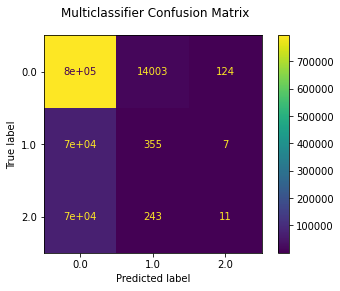

In [121]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test_huge, predictionsFiles_huge)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()

In [123]:
from sklearn.metrics import RocCurveDisplay

In [127]:
from sklearn.preprocessing import LabelBinarizer

In [129]:
label_binarizer = LabelBinarizer().fit(y_test)

In [131]:
y_onehot_huge = label_binarizer.transform(y_test_huge)

In [154]:
y_onehot_huge.shape

(949495, 3)

In [159]:
def ROC_OvR(preds, labels):
    classes = np.unique(labels)
    n_classes = len(classes)

    #go through each class to build a one-versus-rest ROC
    scores = []
    truth = []

    for c in range(1, n_classes):
        in_class = 1.0 *(labels == c)
        score = preds[:,c]

        scores.append(score)
        truth.append(in_class)

    scores = np.array(scores).ravel()
    truth = np.array(truth).ravel()

    return truth, scores


In [161]:
t, s = ROC_OvR(preds, y_test)

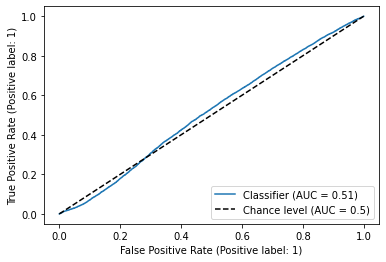

In [162]:
RocCurveDisplay.from_predictions(
    t,
    s,
    plot_chance_level=True
)

In [110]:
#model.save('my_model.keras')

In [111]:
#model.save('my_model.h5')

In [22]:
#loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

112434/112434 - 87s - loss: 0.5151 - sparse_categorical_accuracy: 0.7878 - 87s/epoch - 778us/step
Restored model, accuracy: 78.78%
